In [1]:
from data.generators import get_generator
from data.eval_utils import *
from collections import Counter
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

In [16]:
model_name = 'UnguidedImputer'
dataset = 'GTEx'
pathway = 'Alzheimer'
m_low = 0.5
m_high = 0.5
inplace = False

generator = get_generator(dataset)(pathway=pathway,
                                   m_low=m_low,
                                   m_high=m_high)

Dataset: GTEx


In [19]:
imputer = tf.keras.models.load_model('/local/scratch/rv340/gtex_imputation/checkpoints/{}_inplace{}_{}'.format(model_name, inplace, pathway))
# imputer = tf.keras.models.load_model('/local/scratch/rv340/gtex_imputation/checkpoints/{}_{}'.format(model_name, pathway))

In [22]:
x, _ = generator.test_sample_MCAR()
x, cc, nc, mask = x
x_obs = mask * x
x_miss = (1 - mask) * x
x_imp = imputer((x_obs, cc, nc, (mask, mask)), training=False)  # imputer.impute((x_observed, cc, nc, mask))
r2 = r2_scores(x, x_imp, mask)
np.mean(r2)

0.63214254

# Performance across tissue types

In [25]:
r2s = []
nruns = 10
for n in tqdm(range(nruns)):
    x_extended, cc_extended, nc_extended, mask_extended = extend_dataset(x, cc, nc, cc[:, -1])
    x_obs_extended = mask_extended * x_extended
    x_miss_extended = (1 - mask_extended) * x_extended
    x_imp_extended = imputer((x_obs_extended, cc_extended, nc_extended, (mask_extended, mask_extended))).numpy()
    r2_pertissue = r2_scores_3d(x_extended, x_imp_extended, mask_extended)
    r2s.append(r2_pertissue)
print('Performance on extended test set {:.4f} +- {:.4f}'.format(np.mean(r2s), np.std(r2s)))

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Performance on extended test set 0.6114 +- 0.2328


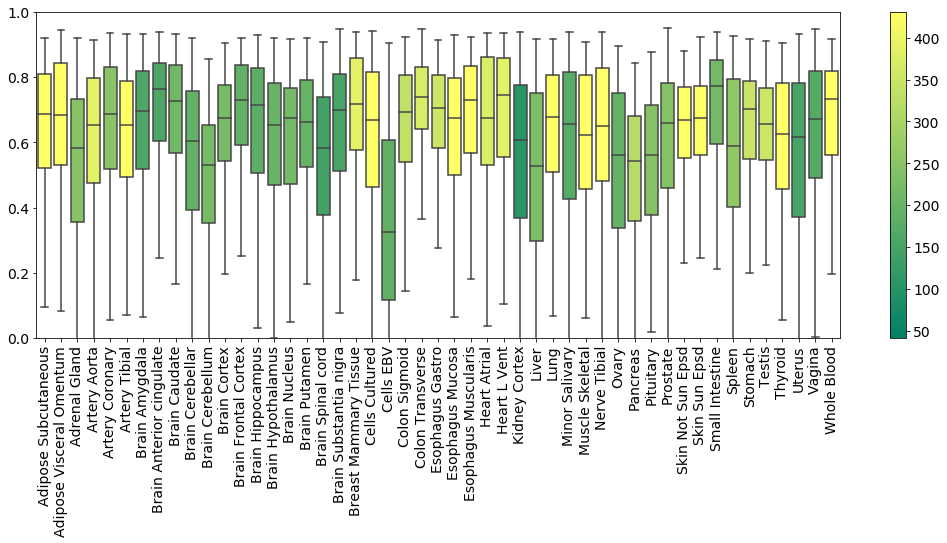

In [26]:
tissues_train = generator.cat_covs_train[:, -1]
tissues_dict_inv = np.array(list(sorted(set(generator.tissues))))
nb_tissues = len(tissues_dict_inv)
counter_train = Counter(tissues_train)
nb_train = np.array([counter_train[t] for t in np.arange(nb_tissues)])
fig=plt.figure(figsize=(18, 6))
plt.rc('font', size=14)
plt.tight_layout()
box_plot_scores(r2_pertissue, nb_train, [t.replace('_', ' ') for t in tissues_dict_inv])
plt.savefig('figures/r2_scores_horizontal_{}_{}.pdf'.format(model_name, pathway), bbox_inches = 'tight', pad_inches = 0)

# Save statistics
df = pd.DataFrame(data=r2_pertissue, index=tissues_dict_inv, columns=generator.gene_symbols)
df.apply(pd.DataFrame.describe, axis=1).to_csv('results/R2_stats_per_tissue_{}_{}.csv'.format(model_name, pathway));

In [27]:
imputer.summary()

Model: "UnguidedImputer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 273)               3633738   
Total params: 3,633,738
Trainable params: 3,627,614
Non-trainable params: 6,124
_________________________________________________________________


# Top / last genes analysis

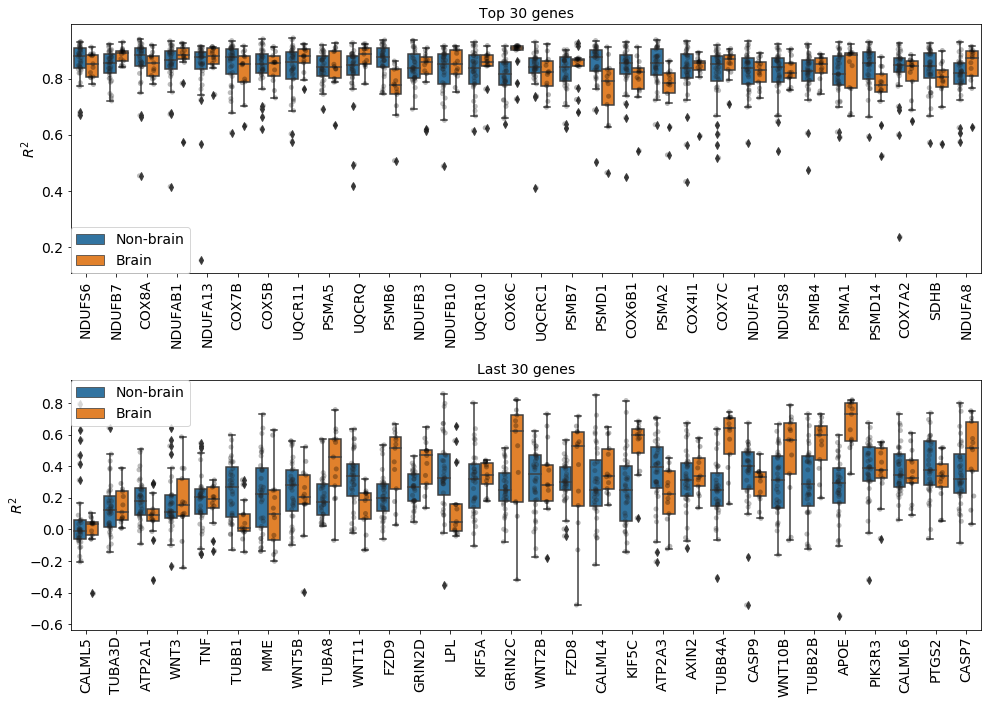

In [28]:
plt.figure(figsize=(14, 10))
n_genes = 30
brain_tissues = ['Brain' if 'Brain' in t else 'Non-brain' for t in tissues_dict_inv]

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

plt.subplot(2, 1, 1)
means = np.mean(r2s, axis=0)
df = pd.DataFrame({s: means[:, i] for i, s in enumerate(generator.gene_symbols)})
df = df.reindex(df.mean().sort_values(ascending=False).index, axis=1)
df = df.iloc[:, :n_genes]
brain_tissues = ['Brain' if 'Brain' in t else 'Non-brain' for t in tissues_dict_inv]
df['Tissue'] = brain_tissues  # tissues_dict_inv
df = df.melt(id_vars='Tissue', var_name='gene', value_name='$R^2$')
df.head()
ax = sns.stripplot(x="gene", y="$R^2$", hue='Tissue', color='black', data=df, alpha=0.3, dodge=True)
sns.boxplot(x="gene", y="$R^2$", hue='Tissue', data=df, showfliers=True)
ax.legend_.remove()
plt.ylabel("$R^2$", size=14)
plt.xlabel("", size=14)
plt.xticks(rotation=90)
l = plt.legend(handles[0:2], labels[0:2],  loc=3, borderaxespad=0.)
plt.title('Top {} genes'.format(n_genes), size=14)

plt.subplot(2, 1, 2)
means = np.mean(r2s, axis=0)
df = pd.DataFrame({s: means[:, i] for i, s in enumerate(generator.gene_symbols)})
df = df.reindex(df.mean().sort_values(ascending=True).index, axis=1)
df = df.iloc[:, :n_genes]
brain_tissues = ['Brain' if 'Brain' in t else 'Non-brain' for t in tissues_dict_inv]
df['Tissue'] = brain_tissues  # tissues_dict_inv
df = df.melt(id_vars='Tissue', var_name='gene', value_name='$R^2$')
df.head()
ax = sns.stripplot(x="gene", y="$R^2$", hue='Tissue', color='black', data=df, alpha=0.3, dodge=True)
sns.boxplot(x="gene", y="$R^2$", hue='Tissue', data=df, showfliers=True)
plt.ylabel("$R^2$", size=14)
plt.xlabel("", size=14)
plt.xticks(rotation=90)
plt.title('Last {} genes'.format(n_genes), size=14)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],  loc=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig('figures/top_last_30_genes_{}_{}.pdf'.format(model_name, pathway), bbox_inches = 'tight', pad_inches = .1);

Text(0.5, 1.0, 'Top 30 genes')

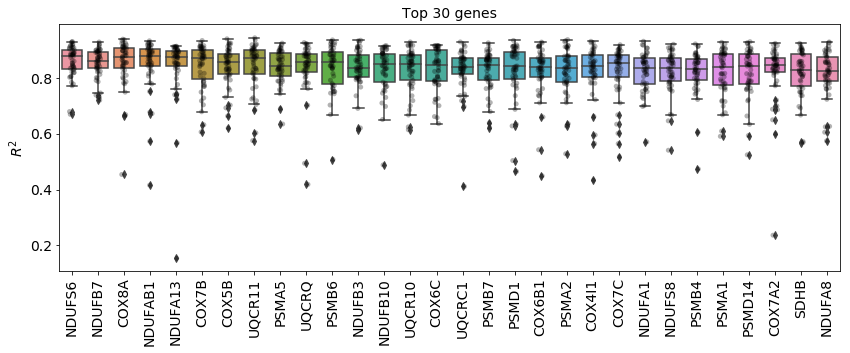

In [29]:
plt.figure(figsize=(14, 10))
n_genes = 30
# brain_tissues = ['Brain' if 'Brain' in t else 'Non-brain' for t in tissues_dict_inv]

plt.subplot(2, 1, 1)
means = np.mean(r2s, axis=0)
df = pd.DataFrame({s: means[:, i] for i, s in enumerate(generator.gene_symbols)})
df = df.reindex(df.mean().sort_values(ascending=False).index, axis=1)
df = df.iloc[:, :n_genes]
# df['Tissue'] = brain_tissues  # tissues_dict_inv
# df = df.melt(id_vars='Tissue', var_name='gene', value_name='$R^2$')
# df.head()
df = df.rename_axis("gene", axis=1)
df = df.rename_axis("$R^2$", axis=0)

ax = sns.stripplot(color='black', data=df, alpha=0.3, dodge=True)
sns.boxplot(data=df, showfliers=True)
# ax.legend_.remove()
plt.ylabel("$R^2$", size=14)
plt.xlabel("", size=14)
plt.xticks(rotation=90)
plt.title('Top {} genes'.format(n_genes), size=14)

In [30]:
means = np.mean(r2s, axis=0)
df = pd.DataFrame({s: means[:, i] for i, s in enumerate(generator.gene_symbols)})
df = df.reindex(df.mean().sort_values(ascending=False).index, axis=1)

In [31]:
df.head()

,NDUFS6,NDUFB7,COX8A,NDUFAB1,NDUFA13,COX7B,COX5B,UQCR11,PSMA5,UQCRQ,...,WNT11,TUBA8,WNT5B,MME,TUBB1,TNF,WNT3,ATP2A1,TUBA3D,CALML5
0,0.900988,0.897435,0.916649,0.906359,0.878997,0.882115,0.899649,0.909980,0.794214,0.888458,...,0.335133,0.287999,0.302554,0.465239,0.155395,0.218551,0.162375,0.094596,0.114449,0.056093
1,0.922618,0.912611,0.938120,0.919017,0.899670,0.906498,0.905707,0.912988,0.865743,0.919281,...,0.408916,0.023346,0.263435,0.727657,0.466405,0.073976,0.099073,0.005354,0.127913,-0.111247
2,0.669969,0.738965,0.664128,0.827082,0.798574,0.770121,0.833102,0.729597,0.854356,0.773193,...,0.283902,0.171941,0.197482,-0.080581,-0.127184,0.008356,0.076780,0.097931,0.179280,-0.033833
3,0.904396,0.835881,0.881843,0.903367,0.887495,0.871944,0.868245,0.798468,0.868341,0.843753,...,0.317473,0.066906,0.083495,0.248516,0.432932,0.268611,0.074677,0.186184,0.180746,0.043231
4,0.874262,0.835739,0.908648,0.919780,0.894218,0.884133,0.886634,0.892810,0.884234,0.833012,...,0.418985,0.052156,-0.020001,0.504884,0.281652,0.197699,0.215719,0.212382,0.096167,0.003978


In [15]:
df.mean().sort_values(ascending=False).to_csv('results/R2_stats_per_gene_{}_{}.csv'.format(model_name, pathway));

/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [32]:
for s in df.columns.values:
    print(s)

NDUFS6
NDUFB7
COX8A
NDUFAB1
NDUFA13
COX7B
COX5B
UQCR11
PSMA5
UQCRQ
PSMB6
NDUFB3
NDUFB10
UQCR10
COX6C
UQCRC1
PSMB7
PSMD1
COX6B1
PSMA2
COX4I1
COX7C
NDUFA1
NDUFS8
PSMB4
PSMA1
PSMD14
COX7A2
SDHB
NDUFA8
PSMD8
NDUFB8
NDUFB9
PSMA7
NDUFA2
UQCRFS1
PSMA6
PSMA3
PSMC3
PSMC2
COX5A
PSMD7
PSMD6
PSMD3
PSMC4
PSMD4
PSMD2
UQCRC2
NDUFB6
CYC1
PSMB1
COX6A1
PSMC1
UQCRH
EIF2S1
VDAC1
PSMB2
NDUFA9
ADRM1
NDUFV2
NDUFS3
PSMA4
NDUFB2
PSMB5
NDUFA11
NDUFA4
NDUFA12
NDUFB1
NDUFS1
VDAC2
NDUFB11
PSMC5
NDUFC1
PSMD13
HSD17B10
SLC25A5
NDUFC2
RELA
NDUFB5
NDUFB4
PSMD12
NDUFA3
NDUFV1
VDAC3
NDUFA6
NDUFS4
SDHD
BECN1
UQCRB
PSMD11
NDUFS7
NDUFS5
CSNK2B
CYCS
PSMD9
PSMC6
TUBB4B
NDUFA5
MAP2K2
ATF6
CHUK
ATP2A2
CSNK2A1
MAPK1
BAD
TUBA1B
KLC2
KIF5B
MTOR
PIK3CA
PSENEN
HRAS
CDK5
NRAS
TUBA1C
RB1CC1
CALM3
SDHA
TUBB
COX7A2L
SLC25A4
ULK1
TNFRSF1A
MAPK9
PPP3CB
GSK3B
DVL1
NDUFS2
AKT3
RTN4
CALM2
TUBB6
GAPDH
RTN3
CALM1
ATG2B
KRAS
AKT2
SDHC
APH1A
CAPN1
IDE
AXIN1
ARAF
ADAM17
PIK3CB
BRAF
CSNK1A1
NFKB1
PSEN1
ATG2A
MAP2K1
SLC25A6
PIK3R4
AKT1
WIPI2
PIK3C

# Performance on TCGA across missing rates

In [26]:
def scores_missing_rate(x_gt, cc, nc, imputer, repeats=10):
    nb_genes = x_gt.shape[-1]
    scores = []
    xs = np.arange(0.05, 0.9, 0.05)
    
    for m_rate in xs:
        for r in range(repeats):
            mask = sample_mask(x_gt.shape[0], nb_genes, m_low=m_rate, m_high=m_rate)
            
            x_obs = mask * x_gt
            x_miss = (1 - mask) * x_gt
            x_imp = imputer((x_obs, cc, nc, mask))  # imputer.impute((x_observed, cc, nc, mask))
            r2 = r2_scores(x_gt, x_imp, mask)
            scores.append(r2)

        print('Missing rate: {:.2f}. R^2: {:.2f}'.format(m_rate, np.nanmean(r2)))
    scores = np.reshape(scores, (-1, repeats, r2.shape[0]))
    
    return xs, scores

def plot_r2_missingrate(xs, scores, label=None):
    means = np.nanmean(scores, axis=(1, 2)) #  np.array([np.nanmean(s) for s in scores_GTEx])
    stds = np.nanmean(np.nanstd(scores, axis=1), axis=-1)
    
    xs_ = xs
    means_ = means
    stds_ = stds
    df = pd.DataFrame(data=np.array([xs_, means_, stds_]).T, columns=['$1 -$missing rate', '$R^2$', 'std'])
    # ax = sns.lineplot(x='$1 -$missing rate', y='$R^2$', data=df, label=label)
    p = plt.plot(xs_, means_, label=label)[0]
    plt.plot(xs_, (means_-stds_), linestyle='dashed', alpha=0.2, color=p.get_color())
    plt.plot(xs_, (means_+stds_), linestyle='dashed', alpha=0.2,  color=p.get_color())
    ax = plt.gca()
    ax.fill_between(xs_, (means_-stds_), (means_+stds_), alpha=.1,);

In [27]:
sg = []
st = []
for i, tcga_tissue in enumerate(['LAML', 'BRCA', 'LUAD']):
    tcga_generator = get_generator('TCGA')(cancer_type=tcga_tissue,
                                           gene_symbols=generator.gene_symbols,
                                           pathway=pathway,
                                           m_low=m_low,
                                           m_high=m_high)
    # Get TCGA data
    x_TCGA, cc_TCGA, nc_TCGA = tcga_generator.test_sample()
    t_idx = tcga_generator.tissue_idx
    t = tcga_generator.tissue
    
    # Get corresponding GTEx data
    x_GTEx, cc_GTEx, nc_GTEx = generator.test_sample()
    idxs_GTEx = np.argwhere(cc_GTEx[:, -1] == t_idx).ravel()
    x_GTEx = x_GTEx[idxs_GTEx]
    cc_GTEx = cc_GTEx[idxs_GTEx]
    nc_GTEx = nc_GTEx[idxs_GTEx]

    print('GTEx {}'.format(t))
    xs, scores_GTEx = scores_missing_rate(x_GTEx, cc_GTEx, nc_GTEx, imputer)
    print('Missing rate 0.5, R^2: {} ({})'.format(np.nanmean(scores_GTEx[9]), np.nanmean(np.nanstd(scores_GTEx[9], axis=0))))
    print('TCGA {}'.format(tcga_tissue))
    _, scores_TCGA = scores_missing_rate(x_TCGA, cc_TCGA, nc_TCGA, imputer)
    print('Missing rate 0.5, R^2: {} ({})'.format(np.nanmean(scores_TCGA[9]), np.nanmean(np.nanstd(scores_TCGA[9], axis=0))))

    sg.append(scores_GTEx)
    st.append(scores_TCGA)

Dataset: TCGA


/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/auto/homes/rv340/gtex_imputation/data/data_utils.py:35: RuntimeWarning: invalid value encountered in true_divide
  return (x - mean) / std


GTEx Whole_Blood
Missing rate: 0.05. R^2: 0.24
Missing rate: 0.10. R^2: 0.43
Missing rate: 0.15. R^2: 0.55
Missing rate: 0.20. R^2: 0.61
Missing rate: 0.25. R^2: 0.65
Missing rate: 0.30. R^2: 0.67
Missing rate: 0.35. R^2: 0.69
Missing rate: 0.40. R^2: 0.70
Missing rate: 0.45. R^2: 0.71
Missing rate: 0.50. R^2: 0.71
Missing rate: 0.55. R^2: 0.71
Missing rate: 0.60. R^2: 0.71
Missing rate: 0.65. R^2: 0.70
Missing rate: 0.70. R^2: 0.70
Missing rate: 0.75. R^2: 0.69
Missing rate: 0.80. R^2: 0.67
Missing rate: 0.85. R^2: 0.65
Missing rate 0.5, R^2: 0.7096164226531982 (0.03492847830057144)
TCGA LAML


/auto/homes/rv340/gtex_imputation/data/eval_utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  r_sq = 1 - ss_res / ss_tot


Missing rate: 0.05. R^2: 0.13
Missing rate: 0.10. R^2: 0.24
Missing rate: 0.15. R^2: 0.31
Missing rate: 0.20. R^2: 0.35
Missing rate: 0.25. R^2: 0.37
Missing rate: 0.30. R^2: 0.38
Missing rate: 0.35. R^2: 0.39
Missing rate: 0.40. R^2: 0.39
Missing rate: 0.45. R^2: 0.39
Missing rate: 0.50. R^2: 0.39
Missing rate: 0.55. R^2: 0.39
Missing rate: 0.60. R^2: 0.39
Missing rate: 0.65. R^2: 0.38
Missing rate: 0.70. R^2: 0.38
Missing rate: 0.75. R^2: 0.37
Missing rate: 0.80. R^2: 0.35
Missing rate: 0.85. R^2: 0.34
Missing rate 0.5, R^2: 0.39433706847742545 (0.06488178090077217)
Dataset: TCGA


/auto/homes/rv340/adversarial-gtex/gtexenv/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


GTEx Breast_Mammary_Tissue
Missing rate: 0.05. R^2: 0.26
Missing rate: 0.10. R^2: 0.46
Missing rate: 0.15. R^2: 0.59
Missing rate: 0.20. R^2: 0.65
Missing rate: 0.25. R^2: 0.69
Missing rate: 0.30. R^2: 0.71
Missing rate: 0.35. R^2: 0.73
Missing rate: 0.40. R^2: 0.74
Missing rate: 0.45. R^2: 0.75
Missing rate: 0.50. R^2: 0.75
Missing rate: 0.55. R^2: 0.75
Missing rate: 0.60. R^2: 0.75
Missing rate: 0.65. R^2: 0.74
Missing rate: 0.70. R^2: 0.74
Missing rate: 0.75. R^2: 0.73
Missing rate: 0.80. R^2: 0.71
Missing rate: 0.85. R^2: 0.69
Missing rate 0.5, R^2: 0.7505776286125183 (0.03960563242435455)
TCGA BRCA
Missing rate: 0.05. R^2: 0.14
Missing rate: 0.10. R^2: 0.26
Missing rate: 0.15. R^2: 0.33
Missing rate: 0.20. R^2: 0.37
Missing rate: 0.25. R^2: 0.39
Missing rate: 0.30. R^2: 0.41
Missing rate: 0.35. R^2: 0.42
Missing rate: 0.40. R^2: 0.42
Missing rate: 0.45. R^2: 0.43
Missing rate: 0.50. R^2: 0.43
Missing rate: 0.55. R^2: 0.43
Missing rate: 0.60. R^2: 0.43
Missing rate: 0.65. R^2: 0.40

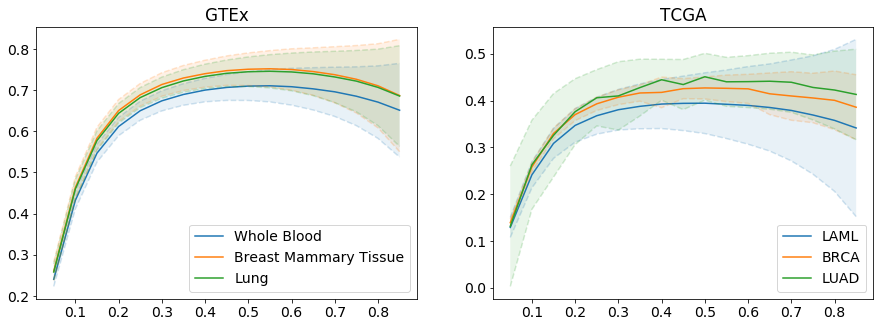

In [31]:
plt.figure(figsize=(15, 5))
plt.tight_layout()
plt.subplot(1, 2, 1)
plot_r2_missingrate(xs, sg[0], 'Whole Blood')
plot_r2_missingrate(xs, sg[1], 'Breast Mammary Tissue')
plot_r2_missingrate(xs, sg[2], 'Lung')
plt.legend()
plt.title('GTEx')

plt.subplot(1, 2, 2)
plot_r2_missingrate(xs, st[0], 'LAML')
plot_r2_missingrate(xs, st[1], 'BRCA')
plot_r2_missingrate(xs, st[2], 'LUAD')

plt.title('TCGA')
plt.legend()
plt.savefig('figures/r2_missing_rate_{}_{}.pdf'.format(model_name, pathway), bbox_inches = 'tight', pad_inches = .1);